# What is Gaussian-Mixture Clustering?

Gaussian-Mixture Clustering is a soft clustering method. A soft clustering method means that each datapoint is assigned a probability of belonging to a certain cluster (The K-means algorithm is a hard clustering method since it doesn't assign probabilities).

As in the K-means algorithm, we have k-clusters and each cluster is composed of a mean $\mu$, covariance matrix $\sum_{i}$ and a component weight $\pi_{i}$. This 3 parameters define how the probabilities are distributed for each cluster.

To ensure the Gaussian fits the datapoints belonging to each cluster we use the maximum likelihood:
$$\mathrm{N}(\textbf{x}|\mu, \sum) =\frac{1}{(2\pi)^{D/2}|\sum|^{1/2}}e^{-\frac{1}{2}(\textbf{x}-\mu)^{T}\sum^{-1}(\textbf{x}-\mu)}$$

By taking the natural logarithm of this function:
$$\ln(N(\textbf{x}|\mu, \sum)) = -\frac{D}{2}\ln 2\pi - \frac{1}{2}\ln \sum - \frac{1}{2}(\textbf{x}-\mu)^{T}\sum^{-1}(\textbf{x}-\mu)$$

Maximizing the logarithm of the function (i.e. differentiate the equation respect to the mean and covariance and equate it to 0) we can finde the optimal parameter values. 

Since we are dealing with $k$ gaussians things get more complicated. An easier and iterative way to solve this is with the Expectation-Maximization algorithm. For this we need initial means, weights and covariance matrix, we can use the K-means algorithm as out ansatz for the problem.



Text(0.5, 1.0, 'Dataset with two features')

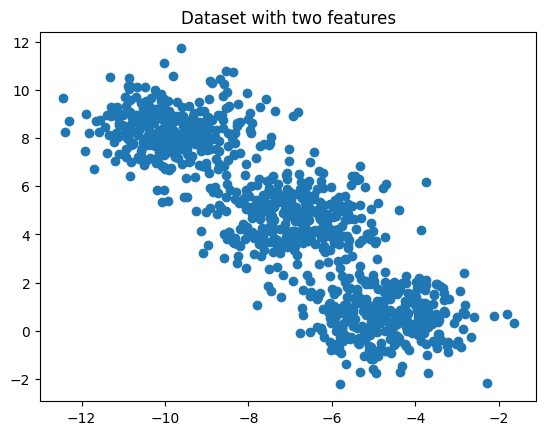

In [1]:
# Lets create a dataset from sklearn.datasets.make_blob
## Create sample dataset with sklearn 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_samples = 1000
n_features = 2
n_classes = 3

data =  make_blobs(n_samples = n_samples, 
                   n_features = n_features, 
                   centers = n_classes,
                   random_state = 12)
feature_data = data[0]
plt.scatter(feature_data[:, 0], feature_data[:, 1])
plt.title('Dataset with two features')

Since we have seen how to create K-mean algorithm in the "K-mean Clustering" notebook, we will use directly the sklearn function.

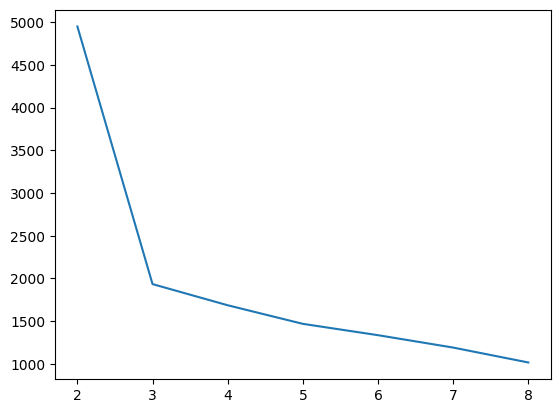

In [2]:
from sklearn.cluster import KMeans

n_k = [2, 3, 4, 5, 6, 7, 8]
inertia = []

for k in n_k:
    kmeans = KMeans(k, random_state = 0)
    kmeans.fit(feature_data)
    inertia.append(kmeans.inertia_)

plt.plot(n_k, inertia)

As expected (since we knew previously that there were 3 clusters) we need 3 clusters.

We need to get the mean, covariance matrix and weights for each cluster. As an initial guess we will assign the initial weights as the percentage of the population belonging to each cluster

In [3]:
import numpy as np
n_classes = 3
kmeans = KMeans(n_classes, random_state = 0)
kmeans.fit(feature_data)

classes = kmeans.labels_

means = kmeans.cluster_centers_
weights = [len(classes[classes == ii])/len(classes) for ii in range(3)]
cov_mat =  [np.identity(feature_data.shape[1]) for ii in range(3)]

Then we go into the expectation step where we need to calculate first
$$
\gamma(z_{nk}) = \frac{\pi_{k}N(\textbf{x}_{n} | \mu_{k}, \Sigma_{k})}{\sum_{j = 1}^{K}\pi_{j}N(\textbf{x}_{n} | \mu_{j}, \Sigma_{j})}
$$

Lets create a function that creates the gaussian distribution $N(\textbf{x}_{n}|\mu_{k},\sum_{k})$

In [4]:
def gauss_dist(X, mu, cov):
    try:
        D = X.shape[1]
        det_cov = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)
        N = (1/((2*np.pi)**(D/2)*det_cov))*np.exp(-(1/2)*(X - mu)@inv_cov@np.transpose(X - mu))
    except: 
        D = 1
        det_cov = cov
        inv_cov = 1/cov
        N = (1/((2*np.pi)**(D/2)*det_cov))*np.exp(-(1/2)*(X - mu)*inv_cov*np.transpose(X - mu))
    return N

Let's try if this works, the values in the diagonal should correspond to the value of each datapoint

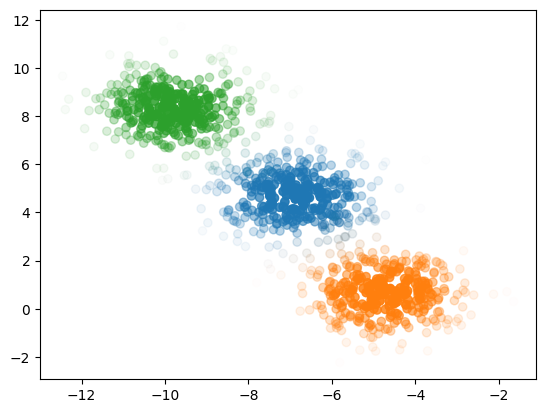

In [5]:
for ii in range(n_classes):
    X = feature_data
    dist = gauss_dist(X, means[ii], cov_mat[ii])

    # We will assign the transparency to each datapoint depending on their diagonal value
    # For this we will normalize the values such that the maximum is 1 

    colors = [dist[ii, ii] for ii in range(len(X))]
    colors = colors/max(colors)
    plt.scatter(X[:,0], X[:, 1], alpha = colors)

As we see in the figure the colors are stronger when close to the center. Now we can calculate the expectation step which basically is the probability for each datapoint to belong to a cluster. If we have $N$ datapoints and $k$ clusters we should have a $Nxk$ matrix where the sum of each row should be 1. 

In [6]:
def exp_step(X, weights, means, covs):
    n_rows = X.shape[0]
    n_classes = len(means)

    gamma = np.zeros((n_rows, n_classes))

    for ii in range(n_classes):

        gamma[:, ii] = weights[ii]*np.diag(gauss_dist(X, means[ii], covs[ii])).flatten()
    
    tot = np.sum(gamma, axis = 1)
    gamma = gamma/np.expand_dims(tot, 1)

    return gamma


Let's check the sum of probabilities of belonging to each cluster is 1 for every datapoint

In [7]:
expected = exp_step(X, weights, means, cov_mat).sum(axis = 1)
expected.mean(), expected.std()

(1.0, 7.143489329906232e-17)

Now in the maximization step we calculate the new weights, means and covariance matrices using the gamma function

In [8]:
def max_step(X, gamma, means, weights, covs):
    n_rows = X.shape[0]
    n_classes = len(means)

    new_means = []
    new_weights = []
    new_covs = []
    for ii in range(n_classes):
        gamma_n = np.expand_dims(gamma[:, ii], axis = 1)
        Nk = np.sum(gamma_n, axis = 0)

        new_means.append(np.sum(gamma_n*X, axis = 0)/Nk)
        new_weights.append(Nk/n_rows)
        new_covs.append((np.transpose(gamma_n*(X-new_means[ii]))@(X-new_means[ii]))/Nk)

    return new_means, new_weights, new_covs

nm, nw, nc = max_step(X, exp_step(X, weights, means, cov_mat), means, weights, cov_mat)

With this we iterate until convergance. We will use a treshold to avoid an infinite-loop where there is no convergence of the system, we will stop if we see that the none of the 3 variables changes more than 0.01%

In [9]:
treshold = 0.0001

import numpy as np
n_classes = 3
kmeans = KMeans(n_classes, random_state = 0)
kmeans.fit(feature_data)

classes = kmeans.labels_

means = kmeans.cluster_centers_
weights = [len(classes[classes == ii])/len(classes) for ii in range(3)]
cov_mat =  [np.identity(feature_data.shape[1]) for ii in range(3)]

diff = 1
steps = 0
while diff > treshold:
    gamma = exp_step(X, weights, means, cov_mat)
    new_means, new_weights, new_cov_mat = max_step(X, gamma, means, weights, cov_mat)

    diff = []
    diff.append(max([np.abs((means[ii]-new_means[ii])/means[ii]).max() for ii in range(n_classes)]))
    diff.append(max([np.abs((weights[ii]-new_weights[ii])/weights[ii]) for ii in range(n_classes)]))
    diff.append(max([np.abs((cov_mat[ii]-new_cov_mat[ii])/cov_mat[ii]).max() for ii in range(n_classes)]))
    diff = max(diff)

    weights = new_weights
    means = new_means
    cov_mat = new_cov_mat
    steps += 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_25736\1355444310.py:23: RuntimeWarning: divide by zero encountered in divide
  diff.append(max([np.abs((cov_mat[ii]-new_cov_mat[ii])/cov_mat[ii]).max() for ii in range(n_classes)]))


Lets plot how the new distributions look like individually

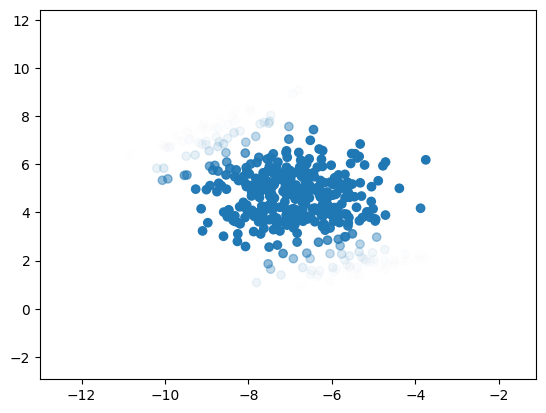

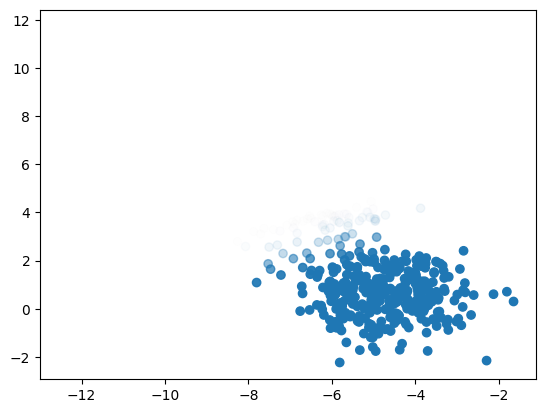

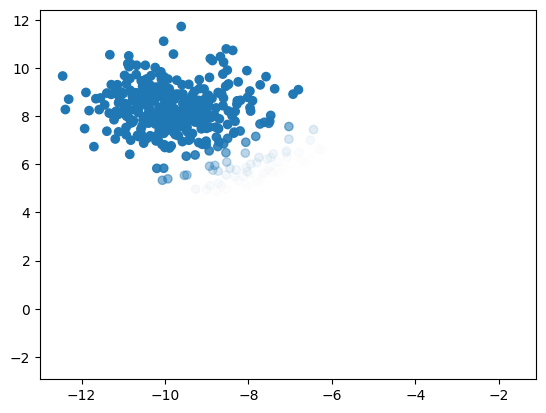

In [10]:
for ii in range(n_classes):
    plt.scatter(X[:,0], X[:, 1], alpha = gamma[:, ii])
    plt.show()

and together

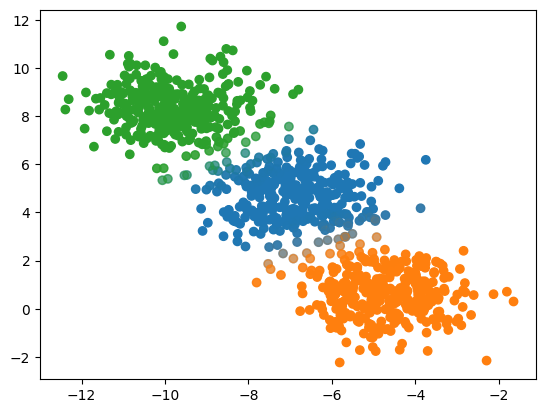

In [11]:
for ii in range(n_classes):
    plt.scatter(X[:,0], X[:, 1], alpha = gamma[:, ii])

We can see that the classes get more transparent when getting closer to the next clusters and remain almost equally strong at the sides